# Setup

In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join("../../..")))  # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, probability_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, ModelProbabilityNetwork
from src.python.models import HierarchicalSdtMptSimulator, MainSimulator
from src.python.metrics import performance_metrics, bootstrapped_metrics
from src.python.helpers import (
    n_clust_obs_f_f,
    log_with_inf_noise_addition,
    computation_times,
    get_repeated_predictions,
)
from src.python.visualization import (
    plot_approximations,
    plot_computation_times,
    plot_calibration_curve_repetition_uncertainty,
)

import numpy as np

np.set_printoptions(suppress=True)
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created
_ = plt.figure()
plt.rcParams["figure.facecolor"] = "w"

<Figure size 432x288 with 0 Axes>

# Load data

In [3]:
comparison_folder = os.path.join(
    os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),
    "data",
    "02_bridge_sampling_comparison",
    "non_nested_models",
)
bridge_file = "2023_01_20_BF_BS"
NN_fixed_file = "2022_12_06_BF_NN_softmax_30epochs"

bridge = pd.read_csv(os.path.join(comparison_folder, bridge_file), sep=" ").reset_index(
    drop=True
)
NN_fixed = pd.read_csv(os.path.join(comparison_folder, NN_fixed_file))
n_div_transitions = pd.read_csv(
    os.path.join(comparison_folder, "2023_01_20_BF_BS_n_div_trans"), sep=" "
).reset_index(drop=True)

results_list = [bridge, NN_fixed]

In [26]:
np.sort(n_div_transitions)

array([[   0,    0],
       [   0,    0],
       [   0,    0],
       [   0,    0],
       [   0, 8069],
       [   0,    0],
       [   0,  240],
       [   0, 2236],
       [   0,    1],
       [   0,    0],
       [   0,    0],
       [   0,    0],
       [   0,    0],
       [   0,    0],
       [   0,    0],
       [   0,    0],
       [   0, 3754],
       [   0,    0],
       [   0,    0],
       [   0, 3451],
       [   0,    0],
       [   0,   52],
       [   0, 2398],
       [   0,  831],
       [   0,  304],
       [   0,    0],
       [   0,    0],
       [   0,    0],
       [   0,    0],
       [   0,    9],
       [   0, 2395],
       [   0,    0],
       [   0,    0],
       [   0,    0],
       [   0,    0],
       [   0,    0],
       [   0,    0],
       [   0, 2300],
       [   0,    0],
       [   0,    0],
       [   0, 3718],
       [   0,   69],
       [   0, 5592],
       [   0, 1045],
       [   0, 2450],
       [   0,    0],
       [   0, 1121],
       [   0,

# Calculate performance metrics

In [4]:
n_bootstrap = 1000
names = ["Bridge sampling", "Neural network"]
metrics = ["Accuracy", "ROC AUC", "MAE", "RMSE", "Log score", "SBC"]

# Calculate performance metrics
perf_metrics = performance_metrics(
    results_list, names=names, metrics=metrics, model_prior=0.5
)

# Calculate bootstrapped performance metrics
metrics_means, metrics_ses = bootstrapped_metrics(
    results_list, n_bootstrap=1000, names=names, metrics=metrics, model_prior=0.5
)

In [5]:
# Raw results
perf_metrics

,Accuracy,ROC AUC,MAE,RMSE,Log score,SBC
Bridge sampling,0.95,0.9856,0.094879,0.217214,0.153464,-0.005661
Neural network,0.95,0.9848,0.096166,0.214380,0.155125,-0.002499


In [6]:
# Bootstrapped means
metrics_means

,Accuracy,ROC AUC,MAE,RMSE,Log score,SBC
Bridge sampling,0.95040,0.985731,0.094458,0.213629,0.152363,-0.004674
Neural network,0.95053,0.984979,0.095837,0.210804,0.154022,-0.001643


In [7]:
# Bootstrapped standard errors
metrics_ses

,Accuracy,ROC AUC,MAE,RMSE,Log score,SBC
Bridge sampling,0.021754,0.008735,0.019541,0.034350,0.041905,0.043607
Neural network,0.021527,0.009248,0.019167,0.034542,0.043053,0.043208


# Investigate influence of # of divergent transitions

In [8]:
142 / 6

23.666666666666668

In [9]:
# Find biggest PMP discrepancies
pmp_divergences = abs(bridge["m1_prob"] - NN_fixed["m1_prob"])

In [10]:
pmp_divergences

0     6.268447e-03
1     8.663375e-03
2     2.605674e-11
3     8.290616e-02
4     1.314845e-04
          ...     
95    1.341176e-04
96    3.950468e-02
97    1.192078e-06
98    9.799226e-06
99    1.251645e-04
Name: m1_prob, Length: 100, dtype: float64

In [11]:
n_div_transitions

,V1,V2
0,0,0
1,0,0
2,0,0
3,0,0
4,8069,0
...,...,...
95,0,0
96,316,0
97,0,0
98,0,0


In [12]:
from src.python.settings import plotting_settings

colors = {
    0: plotting_settings["colors_discrete"][3],
    1: plotting_settings["colors_discrete"][0],
}
model_names = ["SDT", "MPT"]

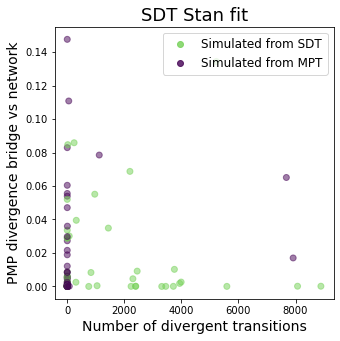

In [13]:
# Inspect SDT Stan fit
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(
    n_div_transitions.iloc[:, 0],
    pmp_divergences,
    c=bridge["true_model"].map(colors),
    alpha=0.5,
)
ax.set_xlabel("Number of divergent transitions", fontsize=14)
ax.set_ylabel("PMP divergence bridge vs network", fontsize=14)
ax.set_title("SDT Stan fit", fontsize=18)
helperlist = [
    plt.plot([], marker="o", ls="", color=color, alpha=0.8)[0]
    for color in colors.values()
]  # hack for legend
legend_test = [
    r"Simulated from " + f"{model_names[0]}",
    r"Simulated from " + f"{model_names[1]}",
]
ax.legend(helperlist, legend_test, fontsize=plotting_settings["fontsize_legends"])

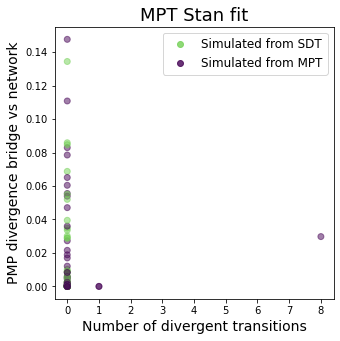

In [14]:
# Inspect MPT Stan fit
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(
    n_div_transitions.iloc[:, 1],
    pmp_divergences,
    c=bridge["true_model"].map(colors),
    alpha=0.5,
)
ax.set_xlabel("Number of divergent transitions", fontsize=14)
ax.set_ylabel("PMP divergence bridge vs network", fontsize=14)
ax.set_title("MPT Stan fit", fontsize=18)
helperlist = [
    plt.plot([], marker="o", ls="", color=color, alpha=0.8)[0]
    for color in colors.values()
]  # hack for legend
legend_test = [
    r"Simulated from " + f"{model_names[0]}",
    r"Simulated from " + f"{model_names[1]}",
]
ax.legend(helperlist, legend_test, fontsize=plotting_settings["fontsize_legends"])

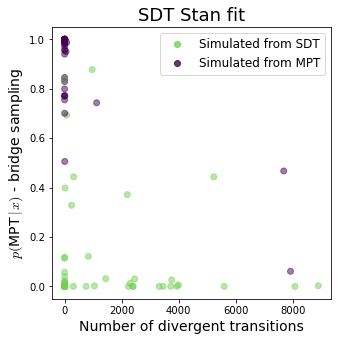

In [15]:
# Inspect SDT Stan fit
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(
    n_div_transitions.iloc[:, 0],
    bridge.loc[:, "m1_prob"],
    c=bridge["true_model"].map(colors),
    alpha=0.5,
)
ax.set_xlabel("Number of divergent transitions", fontsize=14)
ax.set_ylabel(
    r"$p($" + f"{model_names[1]}" + r"$\,|\,\it{x})$" + " - " + "bridge sampling",
    fontsize=14,
)
ax.set_title("SDT Stan fit", fontsize=18)
helperlist = [
    plt.plot([], marker="o", ls="", color=color, alpha=0.8)[0]
    for color in colors.values()
]  # hack for legend
legend_test = [
    r"Simulated from " + f"{model_names[0]}",
    r"Simulated from " + f"{model_names[1]}",
]
ax.legend(helperlist, legend_test, fontsize=plotting_settings["fontsize_legends"])

# Plot computation times as function of data sets

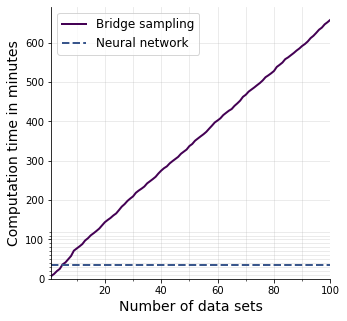

In [16]:
# Calculate computation times
results_time_list = computation_times(results_list)
plot_computation_times(results_time_list, names=names, save=True)

In [17]:
# total bridge sampling time in hours
print((np.sum(bridge["stan_time"]) + np.sum(bridge["bridge_time"])) / 60 / 60)
# total NN time in minutes
print((np.sum(NN_fixed["training_time"][0]) + np.sum(NN_fixed["inference_time"])) / 60)

10.957857921189735
35.91004448166667


In [18]:
# Get minimum number of datasets for which NNs are faster than bridge sampling

print(
    np.where(results_time_list[0] > results_time_list[1])[0][0] + 1
)  # +1 as numpy uses 0-based indexing

5
